# Figure and data notebook

Paper title: Absolute stability predictions via generative models

Authors: Matteo Cagiada, Sergey Ovchinnikov and Kresten Lindorff-Larsen

Correspondence to: K.L.-L. (lindorff@bio.ku.dk)

Notebook by: Matteo Cagiada (matteo.cagiada@bio.ku.dk)


Required folders:


## functions and libraries

In [161]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from Bio import PDB
from Bio.PDB import PDBParser
import warnings
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import bootstrap,entropy
from sklearn.metrics import mean_squared_error
import os
from glob import glob

warnings.filterwarnings('ignore')

In [162]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize']  = 16
mpl.rcParams['legend.fontsize'] = 14

In [163]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_L_D_reordered={0:'R',1:'H',2:'K',3:'D',4:'E',5:'S',6:'T',7:'N',8:'Q',9:'C',10:'G',11:'P',12:'A',13:'V',14:'I',15:'L',16:'M',17:'F',18:'Y',19:'W'}
alphabetAA_D_D_reordered={14:0,6:1,8:2,2:3,3:4,15:5,16:6,11:7,13:8,1:9,5:10,12:11,0:12,17:13,7:14,9:15,10:16,4:17,19:18,18:19}

In [164]:
def spearmansr_output(x,y):
    return sp.stats.spearmanr(x,y)[0]

In [165]:
def pearsonsr_output(x,y):
    return sp.stats.pearsonr(x,y)[0]

In [166]:
def rmse_output(x,y):
    return np.sqrt(mean_squared_error(x,y))

In [167]:
def linear_curve(x, a, b):
    return a * x + b


In [168]:
def load_data_abs(data,wt_seq,start_gap=0,column_score=1):
    df=pd.read_csv(data, delim_whitespace=True, comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,column_score])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    
    for i in range(len(mutation_load)):
        if   mutation_load[i][-1]!= '*' and mutation_load[i][-1]!= 'X':
            if mutation_load[i][-1]!= '=':
                scores[int(mutation_load[i][1:-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][-1]]-1]= float(score_load[i])
            else:
                scores[int(mutation_load[i][1:-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][0]]-1]= float(score_load[i])

    return scores

In [169]:
def load_data_from_df(df,wt_seq,column_name,variant_col='variant',input_dict=None):
    
    mutation_load=df[variant_col].to_numpy()
    score_load=df[column_name].to_numpy()
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for idx, (v, s) in enumerate(zip(mutation_load,score_load)):
        if v[-1]=='=':
            mut_idx = alphabetAA_L_D[wt_seq[int(v[1:-1])-1]]-1
        else:
            mut_idx= alphabetAA_L_D[v[-1]]-1
        if isinstance(s, str):
            scores[int(v[1:-1])-1, mut_idx ]= input_dict[s]
        else:
            if not np.isnan(s):
                scores[int(v[1:-1])-1, mut_idx ]= s
                
    
                    
    return scores

In [240]:
def summed_entropy(data,sequence):
    sum_entropy=[]
    
    for idx,elem in enumerate(sequence):
        sum_entropy.append(-(np.exp(data[idx])*data[idx]).sum(-1))
    
    return np.nansum(np.array(sum_entropy))

def wt_ll(data,sequence,alphabet):
    wt_scores=[]
    
    for idx,elem in enumerate(sequence):
        wt_scores.append((np.exp(data[idx,alphabet[elem]-1])))
        
    return np.nansum(wt_scores)

In [171]:
def calculate_acn(structure, target_chains):
    # Create a distance matrix for all atoms in the specified chains
    residues = []
    for model in structure:
        for chain_id in target_chains:
            try:
                chain = model[chain_id]
                residues.extend([res for res in chain if PDB.is_aa(res)])
            except KeyError:
                print(f"Warning: Chain {chain_id} not found in model {model.id}")

    distances = np.zeros((len(residues), len(residues)))

    for i, res_i in enumerate(residues):
        for j, res_j in enumerate(residues):
            if res_i != res_j:
                try:
                    distance = res_i["CA"] - res_j["CA"]
                    distances[i, j] = distance
                except KeyError:
                    pass  # Ignore residues without alpha carbons

    # Define a cutoff distance for considering contacts
    cutoff_distance = 8.0

    # Calculate the weighted contact number
    #weighted_contact_number = np.sum(np.exp(-(distances / cutoff_distance) ** 2), axis=1)
    absolute_contact_number = np.sum(np.abs(distances) < cutoff_distance)

    #return weighted_contact_number
    return absolute_contact_number



In [172]:
def print_stats_on_axis(x_s,y_s,ax,stats_metrics,coord=[0.75,0.15]):
    ### print the stats on the plot with the correspoding std err obtained through bootstrapping
    
    if stats_metrics=='pearson_r':
        txt_ax_a=pearsonsr_output(x_s,y_s)
        txt_ax_b=bootstrap((x_s,y_s), pearsonsr_output, vectorized=False, paired=True,random_state=rng).standard_error
        ax.text(coord[0],
                coord[1],
                r"$\rho _{p}$: "+str(float("{:.2f}".format(txt_ax_a)))+r'$\pm$'+str(float("{:.2f}".format(txt_ax_b))),
                 ha='center',
                 va ='center',
                 transform = ax.transAxes,fontsize=14)
        
    if stats_metrics=='spearman_r':
        txt_ax_c=spearmansr_output(x_s,y_s)
        txt_ax_d=bootstrap((x_s,y_s), spearmansr_output, vectorized=False, paired=True,random_state=rng).standard_error
        return ax.text(coord[0],
                coord[1],
                r"$\rho _{s}$: "+str(float("{:.2f}".format(txt_ax_c)))+r'$\pm$'+str(float("{:.2f}".format(txt_ax_d))),
                 ha='center',
                 va ='center',
                 transform = ax.transAxes,fontsize=14)        
    if stats_metrics=='rmse':
        txt_ax_e=rmse_output(x_s,y_s)
        ax.text(coord[0],
                coord[1],
                r"RMSE: "+str(float("{:.2f}".format(txt_ax_e))),
                 ha='center',
                 va ='center',
                 transform = ax.transAxes,fontsize=14)        

In [173]:
def sum_single_elements_nANK(df,start,stop):
    if_contribution=0
    for i in range(start,stop+1):
        name_n='ANK_'+str(i)+'-'+str(i)
        if_contribution+=float(df.query('id == @name_n')['dg_IF'])
    return if_contribution

## Analysis

In [174]:
rng = np.random.default_rng()

### Load datasets

#### Tsuboyama2023

In [175]:
rockin_data_df=pd.read_csv('./exp_scores/Tsuboyama2023_Dataset2_Dataset3_20230416.csv')

In [176]:
len(rockin_data_df[rockin_data_df['mut_type'] == 'wt'])

2348

In [177]:
all_unique_pdbs=[]
for idx,row in rockin_data_df.iterrows():
    if not row['WT_name'] in all_unique_pdbs:
            all_unique_pdbs.append(row['WT_name'])

In [178]:
len(all_unique_pdbs)

479

In [179]:
#select only proteins with single substitution variant and wt dG measure

target_pdbs=[]
for idx,row in rockin_data_df.iterrows():
    if row['mut_type'] == 'wt' or not (':' in row['mut_type'] or 'del' in row['mut_type'] or 'ins' in row['mut_type']) :
        if not row['WT_name'] in target_pdbs:
            
            target_pdbs.append(row['WT_name'])

In [180]:
len(target_pdbs)

478

In [181]:
# select for natural proteins only

target_real_pdbs=[]
for elem in target_pdbs:
    if len(elem) == 8:
        target_real_pdbs.append(elem[:4])  

In [182]:
len(target_real_pdbs)

239

In [183]:
## filtering and reduce the csv to single substitution variants
tmp=rockin_data_df[ rockin_data_df['mut_type'].str.contains('ins')==False ]

tmp=tmp[tmp['mut_type'].str.contains('del')==False ]

rockin_data_df_filtered=tmp[tmp['mut_type'].str.contains(':')==False]

In [242]:
## evaluate for the differenr methods the stability score for each natural target protein in the Tsuboyama dataset

#exp
score_exp_rocklin_dg=[]

#baseline pred
score_seq_rocklin_dg=[]
score_acn_rocklin_dg=[]

### generative architectures
score_IF_rocklin_dg=[]
score_IF_entropy_rocklin_dg=[]

###models use as comparison
score_1b_rocklin_dg=[]
score_chroma_rocklin_dg=[]
score_foldx_rocklin_dg=[]


parser = PDB.PDBParser(QUIET=True)
skipped=0

dir_IF_abs=os.path.abspath('./tsuboyama2023/IF_run_absolute/')
dir_chroma_abs=os.path.abspath('./tsuboyama2023/chroma_absolute/')
dir_1b_abs=os.path.abspath('./tsuboyama2023//1b_run_absolute/')
dir_pdbs=os.path.abspath('./tsuboyama2023/AlphaFold_model_tidy_PDBs/')
dir_foldx=os.path.abspath('./tsuboyama2023/foldx/stability_pred_fixed/')

for pdb_sel in target_real_pdbs[:]:
    no_data=False

    ## load the file path from the different sources if required, if one is missing, skip the protein.
    
    df_sel=rockin_data_df_filtered[rockin_data_df_filtered['WT_name'] == pdb_sel+'.pdb']
    seq_sel=df_sel['aa_seq'].iloc[0]
    
    if len(glob(dir_IF_abs+'/*'+pdb_sel+'_*absolute*')) >0:
        abs_IF_file=glob(dir_IF_abs+'/*'+pdb_sel+'_*absolute*')[0]
    else: 
        no_data=True
        print('IF missing on:',pdb_sel)
      
    if len(glob(dir_chroma_abs+'/*'+pdb_sel+'*absolute*')) >0:
        abs_chroma_file=glob(dir_chroma_abs+'/*'+pdb_sel+'_*absolute*')[0]
    else: 
        no_data=True
        print('chroma missing on:',pdb_sel)

    if len(glob(dir_1b_abs+'/*'+pdb_sel+'*absolute*')) >0:
        abs_1b_file=glob(dir_1b_abs+'/*'+pdb_sel+'*absolute*')[0]
    else: 
        no_data=True
        print('1b missing on:',pdb_sel)
        
    if len(glob(dir_pdbs+'/'+pdb_sel+'*.pdb')) >0:
        pdb_location=glob(dir_pdbs+'/'+pdb_sel+'*.pdb')[0]
    else: 
        no_data=True
        print('pdb missing on:',pdb_sel)
        
    if len(glob(dir_foldx+'/'+pdb_sel+'*.fxout')) >0:
        foldx_location=glob(dir_foldx+'/'+pdb_sel+'*.fxout')[0]
    else: 
        no_data=True
        print('pdb missing on:',pdb_sel)
    
    
    ## proceed to load the prediction for the method if required
    if not no_data:
        data_IF_abs=load_data_abs(abs_IF_file,seq_sel)
        data_chroma_abs=load_data_abs(abs_chroma_file,seq_sel)
        data_1b_abs=load_data_abs(abs_1b_file,seq_sel)
        data_foldx=pd.read_csv(foldx_location,sep='\t',header=None)

        ## experimental data point collection for the wt
        sel_score_exp_raw=[]
        for idx,row in df_sel.iterrows():
            if row['mut_type'] =='wt':
                sel_score_exp_raw.append(row['deltaG'])
                
        ## evaluate the different metrics for each protein in the db
        try:
            score_exp_rocklin_dg.append(np.nanmedian(sel_score_exp_raw))

            score_seq_rocklin_dg.append(len(seq_sel))

            score_IF_rocklin_dg.append(wt_ll(data_IF_abs,seq_sel,alphabetAA_L_D))

            score_IF_entropy_rocklin_dg.append(summed_entropy(data_IF_abs,seq_sel))

            score_chroma_rocklin_dg.append(wt_ll(data_chroma_abs,seq_sel,alphabetAA_L_D))
            score_1b_rocklin_dg.append(wt_ll(data_1b_abs,seq_sel,alphabetAA_L_D))       
            score_foldx_rocklin_dg.append(-float(data_foldx[1]))       

            ##evaluate acn
            structure = parser.get_structure("protein", pdb_location)
            acns_sel=calculate_acn(structure,['A'])
            score_acn_rocklin_dg.append(np.nansum(acns_sel))
            
        except:
            print('Error in: ',pdb_sel)



#### Maxwell,2009

In [243]:
maxwell_data_df=pd.read_csv('./exp_scores/maxwell2007_sequences.csv')

In [244]:
maxwell_data_df_novsle=maxwell_data_df[:-1]

In [245]:
#exp
score_exp_maxwell_dg=[]

score_seq_maxwell_dg=[]
score_acn_maxwell_dg=[]

### different metrics
score_IF_maxwell_dg=[]
score_IF_entropy_maxwell_dg=[]

###models use as comparison
score_1b_maxwell_dg=[]
score_chroma_maxwell_dg=[]
score_foldx_maxwell_dg=[]

## evaluate for the differenr methods the stability score for each natural target protein in the Tsuboyama dataset

skipped=0

dir_IF_abs=os.path.abspath('./maxwell2009/if_output/')
dir_chroma_abs=os.path.abspath('./maxwell2009/chroma_absolute_run/')
dir_foldx=os.path.abspath('./maxwell2009/foldx/stability_pred_fixed//')
dir_1b_abs=os.path.abspath('./maxwell2009/esm1b_absolute_run/')
dir_pdbs=os.path.abspath('./maxwell2009/af2_best/')

for idx,row in maxwell_data_df_novsle.iterrows():
    
    ## load the file path from the different sources if required, if one is missing, skip the protein.

    seq_sel=row['sequence']
    no_data=False
    
    if len(glob(dir_IF_abs+'/*'+row['id']+'_*absolute*')) >0:
        abs_IF_file=glob(dir_IF_abs+'/*'+row['id']+'_*absolute*')[0]
    else: 
        no_data=True
        print('IF missing on:',row['id'])
      
    if len(glob(dir_chroma_abs+'/*'+row['id']+'*absolute*')) >0:
        abs_chroma_file=glob(dir_chroma_abs+'/*'+row['id']+'_*absolute*')[0]
    else: 
        no_data=True
        print('chroma missing on:',row['id'])

    if len(glob(dir_1b_abs+'/*'+row['id']+'*absolute*')) >0:
        abs_1b_file=glob(dir_1b_abs+'/*'+row['id']+'*absolute*')[0]
    else: 
        no_data=True
        print('1b missing on:',row['id'])
        
    if len(glob(dir_pdbs+'/'+row['id']+'*.pdb')) >0:
        pdb_location=glob(dir_pdbs+'/'+row['id']+'*.pdb')[0]
    else: 
        no_data=True
        print('pdb missing on:',row['id'])
        
    if len(glob(dir_foldx+'/'+row['id']+'*.fxout')) >0:
        foldx_location=glob(dir_foldx+'/'+row['id']+'*.fxout')[0]
    else: 
        no_data=True
        print('pdb missing on:',row['id'])
    
    ## proceed to load the prediction for the method if required

    if not no_data:
        data_IF_abs=load_data_abs(abs_IF_file,seq_sel)
        data_chroma_abs=load_data_abs(abs_chroma_file,seq_sel)
        data_1b_abs=load_data_abs(abs_1b_file,seq_sel)
        data_foldx=pd.read_csv(foldx_location,sep='\t',header=None)
        
        try:
            ## evaluate the different metrics for each protein in the db

            score_exp_maxwell_dg.append((row['dg']*0.239006)) ## maxwell dG are in kJ/mol --> converted to kcal/mol

            score_seq_maxwell_dg.append(len(seq_sel))

            score_IF_maxwell_dg.append(wt_ll(data_IF_abs,seq_sel,alphabetAA_L_D))
            score_IF_entropy_maxwell_dg.append(summed_entropy(data_IF_abs,seq_sel))

            score_chroma_maxwell_dg.append(wt_ll(data_chroma_abs,seq_sel,alphabetAA_L_D))
            score_1b_maxwell_dg.append(wt_ll(data_1b_abs,seq_sel,alphabetAA_L_D))       
            score_foldx_maxwell_dg.append(-float(data_foldx[1]))

            ##evaluate acn
            structure = parser.get_structure("protein", pdb_location)
            acns_sel=calculate_acn(structure,['A'])
            score_acn_maxwell_dg.append(np.nansum(acns_sel)) ## to fill correclly
        
        except:
            print('Error in: ',row['id'])

pdb missing on: NTL9


### experimental data statistics

In [188]:
## how many sequences
print(len(score_exp_rocklin_dg+score_exp_maxwell_dg))

265


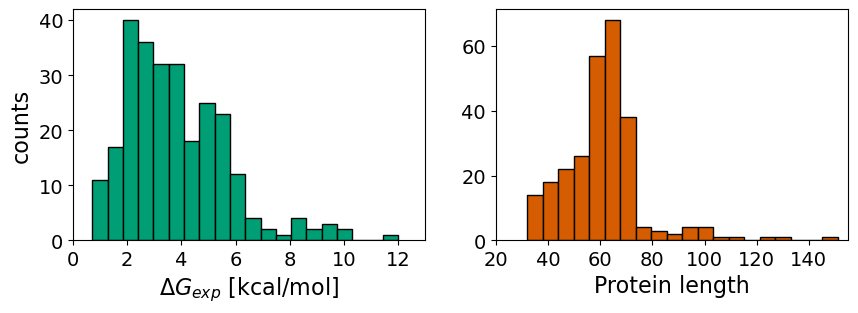

In [189]:
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,3))
ax1.hist(score_exp_rocklin_dg+score_exp_maxwell_dg,edgecolor='k',facecolor='#009e74',bins=20)
ax2.hist(score_seq_rocklin_dg+score_seq_maxwell_dg,edgecolor='k',facecolor='#d55c00',bins=20)
ax1.set_ylabel('counts')
ax1.set_xlim(0,13)
ax1.set_xticks(np.arange(0,13,2))
ax1.set_xlabel(r'$\Delta G_{exp}$ [kcal/mol]')
ax2.set_xlabel('Protein length')
ax2.set_xlim(20,155)
ax2.set_xticks(np.arange(20,155,20))
plt.savefig('./figures_SI/stats_benchmark_dataset.pdf')

In [190]:
pearsonsr_output(score_IF_rocklin_dg+score_IF_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg)

0.6842933580208422

In [191]:
pearsonsr_output(score_IF_rocklin_dg,score_exp_rocklin_dg)

0.6671778952413387

In [192]:
pearsonsr_output(score_IF_maxwell_dg,score_exp_maxwell_dg)

0.5269356337153236

### comparison with baselines

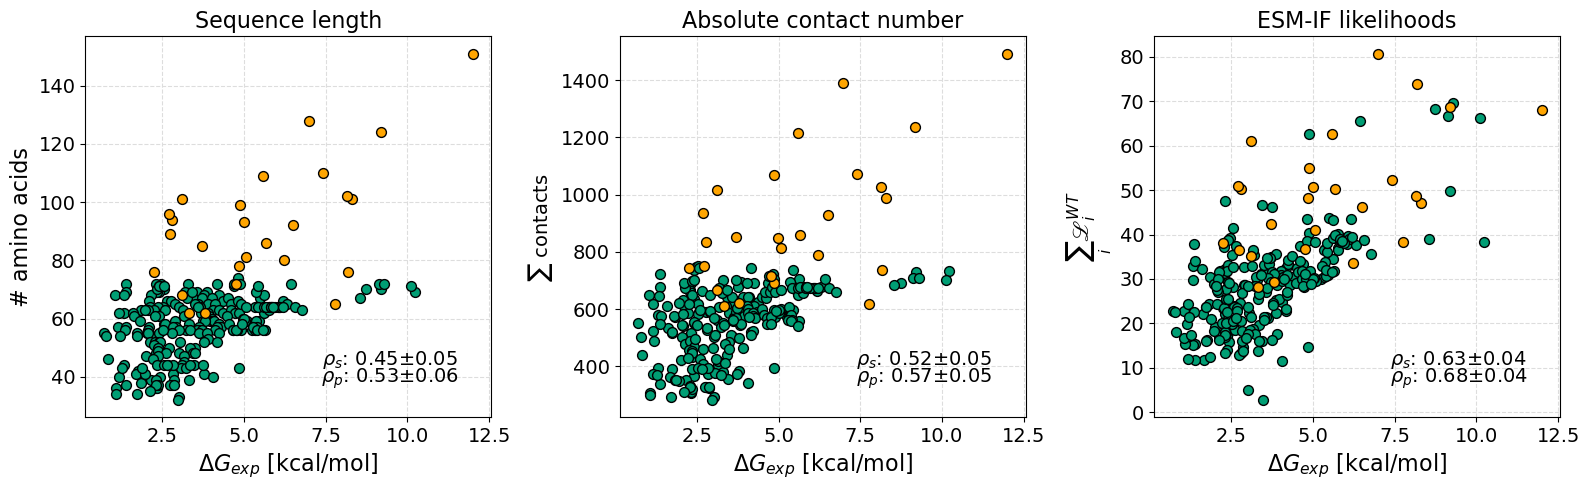

In [193]:
fig,((ax1,ax2,ax3))=plt.subplots(1,3,figsize=(16,5))

ax1.scatter(score_exp_rocklin_dg,score_seq_rocklin_dg,edgecolor='k',facecolor='#009e74',s=50)
ax1.scatter(score_exp_maxwell_dg,score_seq_maxwell_dg,edgecolor='k',facecolor='orange',s=50)

#ax1.set_xlabel(r'$\Delta$g [kcal/mol]',fontsize=14)
ax1.set_ylabel('# amino acids',fontsize=16)
ax1.set_xlabel(r'$\Delta G_{exp}$ [kcal/mol]',fontsize=16)
ax1.set_title('Sequence length',fontsize=16)

ax1.grid(which='major', color='#DDDDDD', linewidth=0.8,ls='--')
ax1.set_axisbelow(True)

print_stats_on_axis(score_seq_rocklin_dg+score_seq_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax1,'spearman_r',coord=[0.75,0.15])
print_stats_on_axis(score_seq_rocklin_dg+score_seq_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax1,'pearson_r',coord=[0.75,0.10])

ax2.scatter(score_exp_rocklin_dg,score_acn_rocklin_dg,edgecolor='k',facecolor='#009e74',s=50)
ax2.scatter(score_exp_maxwell_dg,score_acn_maxwell_dg,edgecolor='k',facecolor='orange',s=50)

ax2.set_xlabel(r'$\Delta G_{exp}$ [kcal/mol]',fontsize=16)
ax2.set_ylabel(r'$\sum$ contacts ',fontsize=14)
ax2.set_title('Absolute contact number',fontsize=16)

ax2.grid(which='major', color='#DDDDDD', linewidth=0.8,ls='--')
ax2.set_axisbelow(True)

print_stats_on_axis(score_acn_rocklin_dg+score_acn_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax2,'spearman_r',coord=[0.75,0.15])
print_stats_on_axis(score_acn_rocklin_dg+score_acn_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax2,'pearson_r',coord=[0.75,0.10])

ax3.scatter(score_exp_rocklin_dg,score_IF_rocklin_dg,edgecolor='k',facecolor='#009e74',s=50)
ax3.scatter(score_exp_maxwell_dg,score_IF_maxwell_dg,edgecolor='k',facecolor='orange',s=50)

ax3.set_ylabel(r'$\sum_i \mathscr{L}_i^{WT}$',fontsize=16)
ax3.set_xlabel(r'$\Delta G_{exp}$ [kcal/mol]',fontsize=16)
ax3.set_title('ESM-IF likelihoods',fontsize=16)

ax3.grid(which='major', color='#DDDDDD', linewidth=0.8,ls='--')
ax3.set_axisbelow(True)

print_stats_on_axis(score_IF_rocklin_dg+score_IF_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax3,'spearman_r',coord=[0.75,0.15])
print_stats_on_axis(score_IF_rocklin_dg+score_IF_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax3,'pearson_r',coord=[0.75,0.10])

fig.tight_layout()

plt.savefig('./figures_SI/SI_dg_comparison_baseline_IF.pdf')

### Comparison with entropy

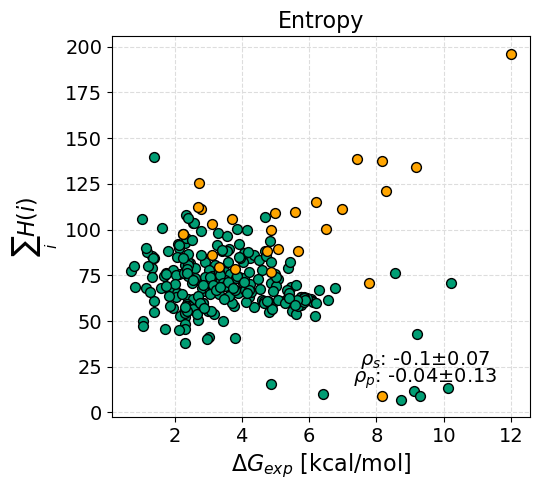

In [246]:
fig,ax1=plt.subplots(1,1,figsize=(5.5,5))

ax1.scatter(score_exp_rocklin_dg,score_IF_entropy_rocklin_dg,edgecolor='k',facecolor='#009e74',s=50)
ax1.scatter(score_exp_maxwell_dg,score_IF_entropy_maxwell_dg,edgecolor='k',facecolor='orange',s=50)

ax1.set_ylabel('$\sum_i H(i)$',fontsize=16)
ax1.set_xlabel(r'$\Delta G_{exp}$ [kcal/mol]',fontsize=16)
ax1.set_title('Entropy',fontsize=16)

ax1.grid(which='major', color='#DDDDDD', linewidth=0.8,ls='--')
ax1.set_axisbelow(True)

print_stats_on_axis(score_IF_entropy_rocklin_dg+score_IF_entropy_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax1,'spearman_r',coord=[0.75,0.15])
print_stats_on_axis(score_IF_entropy_rocklin_dg+score_IF_entropy_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax1,'pearson_r',coord=[0.75,0.10])

fig.tight_layout()

plt.savefig('./figures_SI/SI_dg_comparison_entropy.pdf')

### Comparison different methods

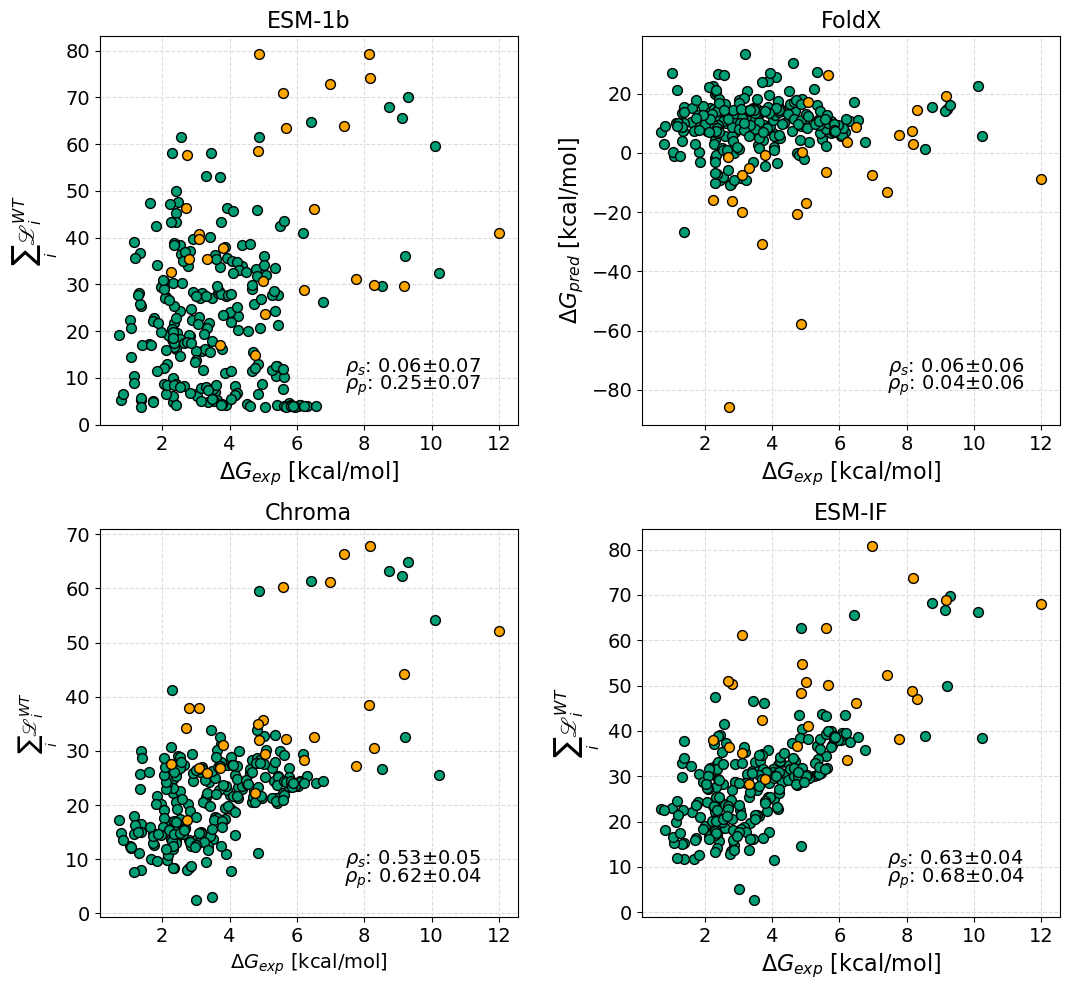

In [195]:
fig,((ax1,ax3),(ax2,ax4))=plt.subplots(2,2,figsize=(11,10))

ax1.scatter(score_exp_rocklin_dg,score_1b_rocklin_dg,edgecolor='k',facecolor='#009e74',s=50)
ax1.scatter(score_exp_maxwell_dg,score_1b_maxwell_dg,edgecolor='k',facecolor='orange',s=50)

#ax1.set_xlabel(r'$\Delta$g [kcal/mol]',fontsize=14)
ax1.set_ylabel(r'$\sum_i \mathscr{L}_i^{WT}$',fontsize=16)
ax1.set_xlabel(r'$\Delta G_{exp}$ [kcal/mol]',fontsize=16)
ax1.set_title('ESM-1b',fontsize=16)

ax1.grid(which='major', color='#DDDDDD', linewidth=0.8,ls='--')
ax1.set_axisbelow(True)

print_stats_on_axis(score_1b_rocklin_dg+score_1b_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax1,'spearman_r',coord=[0.75,0.15])
print_stats_on_axis(score_1b_rocklin_dg+score_1b_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax1,'pearson_r',coord=[0.75,0.10])

ax2.scatter(score_exp_rocklin_dg,score_chroma_rocklin_dg,edgecolor='k',facecolor='#009e74',s=50)
ax2.scatter(score_exp_maxwell_dg,score_chroma_maxwell_dg,edgecolor='k',facecolor='orange',s=50)

ax2.set_xlabel(r'$\Delta G_{exp}$ [kcal/mol]',fontsize=14)
ax2.set_ylabel(r'$\sum_i \mathscr{L}_i^{WT}$',fontsize=14)
ax2.set_title('Chroma',fontsize=16)

ax2.grid(which='major', color='#DDDDDD', linewidth=0.8,ls='--')
ax2.set_axisbelow(True)

print_stats_on_axis(score_chroma_rocklin_dg+score_chroma_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax2,'spearman_r',coord=[0.75,0.15])
print_stats_on_axis(score_chroma_rocklin_dg+score_chroma_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax2,'pearson_r',coord=[0.75,0.10])

ax3.scatter(score_exp_rocklin_dg,score_foldx_rocklin_dg,edgecolor='k',facecolor='#009e74',s=50)
ax3.scatter(score_exp_maxwell_dg,score_foldx_maxwell_dg,edgecolor='k',facecolor='orange',s=50)

ax3.set_ylabel(r'$\Delta G_{pred}$ [kcal/mol]',fontsize=16)
ax3.set_xlabel(r'$\Delta G_{exp}$ [kcal/mol]',fontsize=16)
ax3.set_title('FoldX',fontsize=16)

ax3.grid(which='major', color='#DDDDDD', linewidth=0.8,ls='--')
ax3.set_axisbelow(True)

print_stats_on_axis(score_foldx_rocklin_dg+score_foldx_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax3,'spearman_r',coord=[0.75,0.15])
print_stats_on_axis(score_foldx_rocklin_dg+score_foldx_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax3,'pearson_r',coord=[0.75,0.10])

ax4.scatter(score_exp_rocklin_dg,score_IF_rocklin_dg,edgecolor='k',facecolor='#009e74',s=50)
ax4.scatter(score_exp_maxwell_dg,score_IF_maxwell_dg,edgecolor='k',facecolor='orange',s=50)

ax4.set_ylabel(r'$\sum_i \mathscr{L}_i^{WT}$',fontsize=16)
ax4.set_xlabel(r'$\Delta G_{exp}$ [kcal/mol]',fontsize=16)
ax4.set_title('ESM-IF',fontsize=16)

ax4.grid(which='major', color='#DDDDDD', linewidth=0.8,ls='--')
ax4.set_axisbelow(True)

print_stats_on_axis(score_IF_rocklin_dg+score_IF_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax4,'spearman_r',coord=[0.75,0.15])
print_stats_on_axis(score_IF_rocklin_dg+score_IF_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax4,'pearson_r',coord=[0.75,0.10])

fig.tight_layout()

plt.savefig('./figures_SI/SI_dg_comparison_methods_IF.pdf')

### fitting to exp dG

In [196]:
popt, _ = curve_fit(linear_curve,score_IF_rocklin_dg+score_IF_maxwell_dg, score_exp_rocklin_dg+score_exp_maxwell_dg)
a_if, b_if = popt
print(a_if,b_if)

0.10413378327743603 0.6162549378400894


In [197]:
pred_score_IF_rocklin_dg=[]
for elem in score_IF_rocklin_dg:
    pred_score_IF_rocklin_dg.append(linear_curve(elem,a_if, b_if))

In [198]:
pred_score_IF_maxwell_dg=[]
for elem in score_IF_maxwell_dg:
    pred_score_IF_maxwell_dg.append(linear_curve(elem,a_if, b_if))

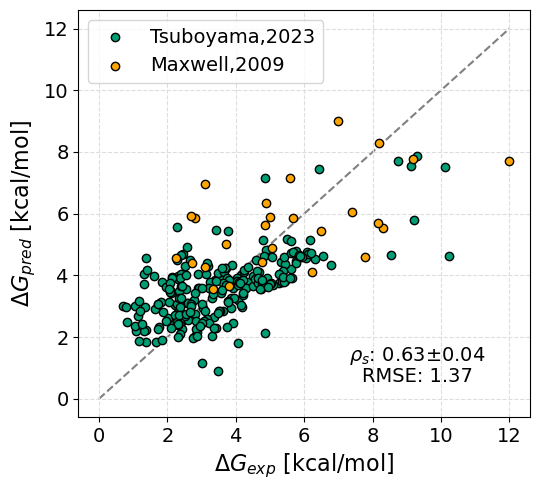

In [199]:
fig,(ax1)=plt.subplots(1,1,figsize=(5.5,5))

ax1.scatter(score_exp_rocklin_dg,pred_score_IF_rocklin_dg,edgecolor='k',facecolor='#009e74',label='Tsuboyama,2023')
ax1.scatter(score_exp_maxwell_dg,pred_score_IF_maxwell_dg,edgecolor='k',facecolor='orange',label='Maxwell,2009')


ax1.grid(which='major', color='#DDDDDD', linewidth=0.8,ls='--')
ax1.set_axisbelow(True)

print_stats_on_axis(pred_score_IF_rocklin_dg+pred_score_IF_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax1,'spearman_r',coord=[0.75,0.15])
print_stats_on_axis(pred_score_IF_rocklin_dg+pred_score_IF_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg,ax1,'rmse',coord=[0.75,0.10])

popt, _ = curve_fit(linear_curve, pred_score_IF_rocklin_dg+pred_score_IF_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg)
a, b= popt
y_line = np.arange(0,13, 1)
# calculate the output for the range
x_line = linear_curve(y_line, a, b)
# create a line plot for the mapping function
ax1.plot(x_line, y_line, '--', color='gray',zorder=-100)
ax1.legend()

ax1.set_xlabel(r'$\Delta G_{exp}$ [kcal/mol]',fontsize=16)
ax1.set_ylabel(r'$\Delta G_{pred}$ [kcal/mol]',fontsize=16)
fig.tight_layout()
plt.savefig('./figures_SI/dg_fit_all.pdf')

### Gruszka,2015

In [200]:
### data from the paper about the tested proteins
pdb_names=['G51_E_G52','G51_single','E_single','G52_single','G51_E_double','E_G52_double']
pdb_sequences=['APKTITELEKKVEEIPFKKERKFNPDLAPGTEKVTREGQKGEKTITTPTLKNPLTGVIISKGEPKEEITKDPINELTEYGPETIAPGHRDEFDPKLPTGEKEEVPGKPGIKNPETGDVVRPPVDSVTKYGPVKGDSIVEKEEIPFEKERKFNPDLAPGTEKVTREGQKGEKTITTPTLKNPLTGEIISKGESKEEITKDPINELTEYGPET',
              'APKTITELEKKVEEIPFKKERKFNPDLAPGTEKVTREGQKGEKTITTPTLKNPLTGVIISKGEPKEEITKDPINELTEYGPET',
              'IAPGHRDEFDPKLPTGEKEEVPGKPGIKNPETGDVVRPPVDSVTK',
              'YGPVKGDSIVEKEEIPFEKERKFNPDLAPGTEKVTREGQKGEKTITTPTLKNPLTGEIISKGESKEEITKDPINELTEYGPET',
              'APKTITELEKKVEEIPFKKERKFNPDLAPGTEKVTREGQKGEKTITTPTLKNPLTGVIISKGEPKEEITKDPINELTEYGPETIAPGHRDEFDPKLPTGEKEEVPGKPGIKNPETGDVVRPPVDSVTK',
              'IAPGHRDEFDPKLPTGEKEEVPGKPGIKNPETGDVVRPPVDSVTKYGPVKGDSIVEKEEIPFEKERKFNPDLAPGTEKVTREGQKGEKTITTPTLKNPLTGEIISKGESKEEITKDPINELTEYGPET']
dg_h20=[7.5,3.2,np.nan,2.8,3.2,6.3]

In [201]:
gruskza_df=pd.DataFrame({'id':pdb_names,'sequence':pdb_sequences,'dg_h20':dg_h20})

In [202]:
score_exp_gruskza_dg=[]
score_seq_gruskza_dg=[]
score_IF_gruskza_dg=[]

dir_IF_abs=os.path.abspath('./gruszka2015/IF_absolute/')

for idx,row in gruskza_df.iterrows():
    seq_sel=row['sequence']
    no_data=False
    
    if len(glob(dir_IF_abs+'/*'+row['id']+'_*absolute*')) >0:
        abs_IF_file=glob(dir_IF_abs+'/*'+row['id']+'_*absolute*')[0]
    else: 
        no_data=True
        print('IF missing on:',row['id'])
    
    if not no_data:
        data_IF_abs=load_data_abs(abs_IF_file,seq_sel)

        score_seq_gruskza_dg.append(len(seq_sel))
        score_IF_gruskza_dg.append(wt_ll(data_IF_abs,seq_sel,alphabetAA_L_D))

        score_exp_gruskza_dg.append((row['dg_h20']))
        
pred_score_IF_gruskza_dg=[]
for elem in score_IF_gruskza_dg:
    pred_score_IF_gruskza_dg.append(linear_curve(elem,a_if, b_if))

In [203]:
gruskza_df['dg_if']=score_IF_gruskza_dg

In [204]:
gruskza_df['pred_dg_if']=pred_score_IF_gruskza_dg

In [205]:
score_IF_gruskza_dg_linear=[]
score_IF_gruskza_dg_linear.append(float(gruskza_df.query("id=='G51_single'")['dg_if'])+float(gruskza_df.query("id=='G52_single'")['dg_if'])+float(gruskza_df.query("id=='E_single'")['dg_if']))
score_IF_gruskza_dg_linear.append(float(gruskza_df.query("id=='G51_single'")['dg_if']))
score_IF_gruskza_dg_linear.append(float(gruskza_df.query("id=='E_single'")['dg_if']))
score_IF_gruskza_dg_linear.append(float(gruskza_df.query("id=='G52_single'")['dg_if']))
score_IF_gruskza_dg_linear.append(float(gruskza_df.query("id=='G51_single'")['dg_if'])+float(gruskza_df.query("id=='E_single'")['dg_if']))
score_IF_gruskza_dg_linear.append(float(gruskza_df.query("id=='G52_single'")['dg_if'])+float(gruskza_df.query("id=='E_single'")['dg_if']))

pred_score_IF_gruskza_dg_linear=[]
for elem in score_IF_gruskza_dg_linear:
    pred_score_IF_gruskza_dg_linear.append(linear_curve(elem,a_if, b_if))

In [206]:
gruskza_df['dg_if_linear']=score_IF_gruskza_dg_linear

In [207]:
gruskza_df['pred_dg_if_linear']=pred_score_IF_gruskza_dg_linear

#### plot figure

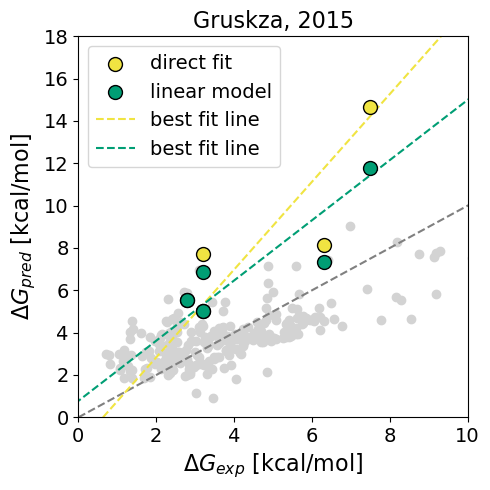

In [208]:
fig,((ax1))=plt.subplots(1,1,figsize=(5,5))

ax1.scatter(score_exp_rocklin_dg+score_exp_maxwell_dg,pred_score_IF_rocklin_dg+pred_score_IF_maxwell_dg,facecolor='lightgray',zorder=-200)
ax1.scatter(gruskza_df['dg_h20'],gruskza_df['pred_dg_if'],edgecolor='k',facecolor='#f0e442',label='direct fit',s=100)
ax1.scatter(gruskza_df['dg_h20'],gruskza_df['pred_dg_if_linear'].to_numpy(),edgecolor='k',facecolor='#009e74',label='linear model',s=100)

ax1.set_xlabel(r'$\Delta G_{exp}$ [kcal/mol]',fontsize=16)
ax1.set_ylabel(r'$\Delta G_{pred}$ [kcal/mol]',fontsize=16)

ax1.set_title('Gruskza, 2015',fontsize=16)
ax1.set_xlim(0,10)
ax1.set_ylim(0,18)

popt, _ = curve_fit(linear_curve, pred_score_IF_rocklin_dg+pred_score_IF_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg)
a, b= popt
y_line = np.arange(0,22, 1)
# calculate the output for the range
x_line = linear_curve(y_line, a, b)
# create a line plot for the mapping function
ax1.plot(x_line, y_line, '--', color='gray',zorder=-100)

entire_dataset=[ [x,y] for i,(x,y) in enumerate(zip(x_line,y_line))]

idx= np.isfinite(gruskza_df['dg_h20'].to_numpy()) & np.isfinite(gruskza_df['pred_dg_if'].to_numpy())
popt, _ = curve_fit(linear_curve, np.array(gruskza_df['pred_dg_if'].to_numpy())[idx],gruskza_df['dg_h20'].to_numpy()[idx])
a, b = popt
y_line = np.arange(0,22, 1)
# calculate the output for the range
x_line = linear_curve(y_line, a, b)
# create a line plot for the mapping function
ax1.plot(x_line, y_line, '--', color='#f0e442',zorder=-100,label='best fit line')

fullstruct_datapoint=[ [x,y] for i,(x,y) in enumerate(zip(x_line,y_line))]

idx= np.isfinite(gruskza_df['dg_h20'].to_numpy()) & np.isfinite(gruskza_df['pred_dg_if_linear'].to_numpy())
popt, _ = curve_fit(linear_curve, np.array(gruskza_df['pred_dg_if_linear'].to_numpy())[idx],gruskza_df['dg_h20'].to_numpy()[idx])
a, b = popt
y_line = np.arange(0,22, 1)
x_line = linear_curve(y_line, a, b)
# create a line plot for the mapping function
ax1.plot(x_line, y_line, '--', color='#009e74',zorder=-100,label='best fit line')

lin_datapoint=[ [x,y] for i,(x,y) in enumerate(zip(x_line,y_line))]


ax1.legend()

fig.tight_layout()

plt.savefig('./figures_SI/dg_comparison_gruszla2015.pdf')

### Mello,2004

In [209]:
mello_df=pd.read_csv('./mello2004/mello2004_exp_information_original_seqs.csv')

In [210]:
score_seq_mello_dg=[]
score_IF_mello_dg=[]

dir_IF_abs=os.path.abspath('./mello2004/IF_run_absolute/')

for idx,row in mello_df.iterrows():
    seq_sel=row['sequence']
    no_data=False
    if len(glob(dir_IF_abs+'/*'+row['id']+'_*absolute*')) >0:
        abs_IF_file=glob(dir_IF_abs+'/*'+row['id']+'_*absolute*')[0]
    else: 
        no_data=True
        print('IF missing on:',row['id'])
    
    if not no_data:
        data_IF_abs=load_data_abs(abs_IF_file,seq_sel)
        
        score_seq_mello_dg.append(len(seq_sel))
        score_IF_mello_dg.append(wt_ll(data_IF_abs,seq_sel,alphabetAA_L_D))
        
pred_score_IF_mello_dg=[]
for elem in score_IF_mello_dg:
    pred_score_IF_mello_dg.append(linear_curve(elem,a_if, b_if))

In [211]:
mello_df['dg_IF']=score_IF_mello_dg
mello_df['pred_dg_IF']=pred_score_IF_mello_dg

#### linear_model

In [212]:
linear_model_if_dg=[]
tested_combinations=[[1,1],[2,2],[3,3],[4,4],[5,5],[6,6],[7,7],
                     [1,2],[2,3],[3,4],[4,5],[5,6],[6,7],
                     [1,7],[1,6],[1,5],[1,4],[4,7],[3,7],[2,7],[2,6],[2,5]]

for coord in tested_combinations:
    linear_model_if_dg.append(sum_single_elements_nANK(mello_df,coord[0],coord[1]))
    
pred_linear_model_if_dg=[]
for elem in linear_model_if_dg:
    pred_linear_model_if_dg.append(linear_curve(elem,a_if, b_if))

In [213]:
mello_df['dg_if_linear']=linear_model_if_dg
mello_df['pred_dg_if_linear']=pred_linear_model_if_dg

#### plot figure

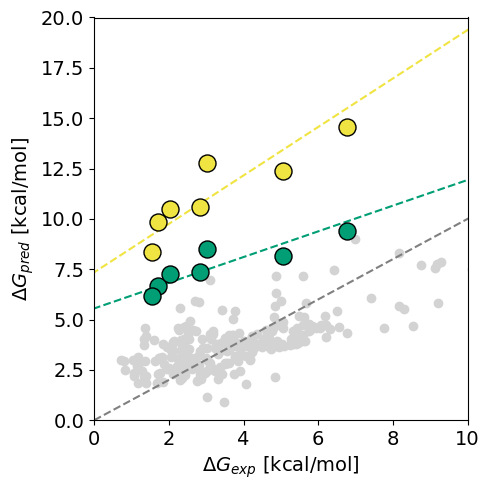

In [214]:
fig,(ax1)=plt.subplots(1,1,figsize=(5,5))

ax1.scatter(score_exp_rocklin_dg+score_exp_maxwell_dg,pred_score_IF_rocklin_dg+pred_score_IF_maxwell_dg,facecolor='lightgray',zorder=-200)
ax1.scatter(mello_df['dg_f'].to_numpy(),mello_df['pred_dg_IF'].to_numpy(),edgecolor='k',facecolor='#f0e442',label='full',s=150)
ax1.scatter(mello_df['dg_f'].to_numpy(),mello_df['pred_dg_if_linear'].to_numpy(),edgecolor='k',facecolor='#009e74',label='linear',s=150)
#ax1.scatter(mello_df['dg_f'].to_numpy(),mello_df['pred_dg_if_interface'].to_numpy(),edgecolor='k',facecolor='#d55c00',label='interface',s=150)

ax1.set_xlabel(r'$\Delta G_{exp}$ [kcal/mol]',fontsize=14)
ax1.set_ylabel(r'$\Delta G_{pred}$ [kcal/mol]',fontsize=14)

ax1.set_xlim(0,10)
ax1.set_ylim(0,20)

popt, _ = curve_fit(linear_curve, pred_score_IF_rocklin_dg+pred_score_IF_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg)
a, b = popt
y_line = np.arange(0,20, 1)
# calculate the output for the range
x_line = linear_curve(y_line, a, b)
# create a line plot for the mapping function
ax1.plot(x_line, y_line, '--', color='gray',zorder=-100)


idx= np.isfinite(mello_df['pred_dg_IF'].to_numpy()) & np.isfinite(mello_df['dg_f'].to_numpy())
popt, _ = curve_fit(linear_curve, mello_df['pred_dg_IF'].to_numpy()[idx],mello_df['dg_f'].to_numpy()[idx])
a, b = popt
y_line = np.arange(0,22, 1)
# calculate the output for the range
x_line = linear_curve(y_line, a, b)
# create a line plot for the mapping function
ax1.plot(x_line, y_line, '--', color='#f0e442',zorder=-100)


idx= np.isfinite(mello_df['pred_dg_if_linear'].to_numpy()) & np.isfinite(mello_df['dg_f'].to_numpy())
popt, _ = curve_fit(linear_curve, mello_df['pred_dg_if_linear'].to_numpy()[idx],mello_df['dg_f'].to_numpy()[idx])
a, b = popt
y_line = np.arange(0,22, 1)
# calculate the output for the range
x_line = linear_curve(y_line, a, b)
# create a line plot for the mapping function
ax1.plot(x_line, y_line, '--', color='#009e74',zorder=-100)

# idx= np.isfinite(mello_df['pred_dg_if_interface'].to_numpy()) & np.isfinite(mello_df['dg_f'].to_numpy())
# popt, _ = curve_fit(linear_curve, mello_df['pred_dg_if_interface'].to_numpy()[idx],mello_df['dg_f'].to_numpy()[idx])
# a, b = popt
# y_line = np.arange(0,20, 1)
# # calculate the output for the range
# x_line = linear_curve(y_line, a, b)
# # create a line plot for the mapping function
# ax1.plot(x_line, y_line, '--', color='#d55c00',zorder=-100)

fig.tight_layout()

plt.savefig('./figures_SI/dg_comparison_3models_mello2004.pdf')

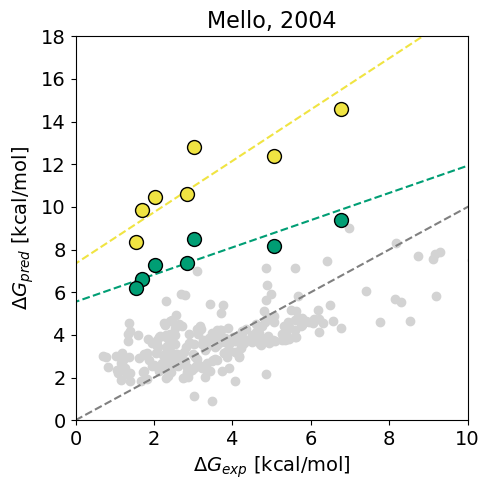

In [215]:
fig,(ax1)=plt.subplots(1,1,figsize=(5,5))

ax1.scatter(score_exp_rocklin_dg+score_exp_maxwell_dg,pred_score_IF_rocklin_dg+pred_score_IF_maxwell_dg,facecolor='lightgray',zorder=-200)
ax1.scatter(mello_df['dg_f'].to_numpy(),mello_df['pred_dg_IF'].to_numpy(),edgecolor='k',facecolor='#f0e442',label='full',s=100)
ax1.scatter(mello_df['dg_f'].to_numpy(),mello_df['pred_dg_if_linear'].to_numpy(),edgecolor='k',facecolor='#009e74',label='linear',s=100)

ax1.set_xlabel(r'$\Delta G_{exp}$ [kcal/mol]',fontsize=14)
ax1.set_ylabel(r'$\Delta G_{pred}$ [kcal/mol]',fontsize=14)

ax1.set_xlim(0,10)
ax1.set_ylim(0,18)

popt, _ = curve_fit(linear_curve, pred_score_IF_rocklin_dg+pred_score_IF_maxwell_dg,score_exp_rocklin_dg+score_exp_maxwell_dg)
a, b = popt
y_line = np.arange(0,20, 1)
# calculate the output for the range
x_line = linear_curve(y_line, a, b)
# create a line plot for the mapping function
ax1.plot(x_line, y_line, '--', color='gray',zorder=-100,label='best fit line')


idx= np.isfinite(mello_df['pred_dg_IF'].to_numpy()) & np.isfinite(mello_df['dg_f'].to_numpy())
popt, _ = curve_fit(linear_curve, mello_df['pred_dg_IF'].to_numpy()[idx],mello_df['dg_f'].to_numpy()[idx])
a, b = popt
y_line = np.arange(0,20, 1)
# calculate the output for the range
x_line = linear_curve(y_line, a, b)
# create a line plot for the mapping function
ax1.plot(x_line, y_line, '--', color='#f0e442',zorder=-100,label='best fit line')


idx= np.isfinite(mello_df['pred_dg_if_linear'].to_numpy()) & np.isfinite(mello_df['dg_f'].to_numpy())
popt, _ = curve_fit(linear_curve, mello_df['pred_dg_if_linear'].to_numpy()[idx],mello_df['dg_f'].to_numpy()[idx])
a, b = popt
y_line = np.arange(0,20, 1)
# calculate the output for the range
x_line = linear_curve(y_line, a, b)
# create a line plot for the mapping function
ax1.plot(x_line, y_line, '--', color='#009e74',zorder=-100,label='best fit line')
ax1.set_title('Mello, 2004',fontsize=16)
fig.tight_layout()

plt.savefig('./figures_SI/dg_comparison_mello2004.pdf')

### Wang, 2016

In [216]:
T4wt_seq= 'MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNCNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRCALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSIWYNQTPNRAKRVITTFRTGTWDAYKNL'
T4mut_seq='MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAAAINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKNL'

In [217]:
pdb_ids=['3DMV','2CLB']

In [218]:
dG_between_states=-8.314*298*np.log(0.03/0.97)*0.239006/1000

In [219]:
data_IF_abs=load_data_abs('./wang2016/IF_run_abs/prism_ESM_IF_t4l_wt_A_absolute.txt',T4wt_seq)
dg_102L_IF=wt_ll(data_IF_abs,T4wt_seq,alphabetAA_L_D)
pred_dg_102L_IF=linear_curve(dg_102L_IF,a_if, b_if)

In [220]:
data_IF_abs=load_data_abs('./wang2016/IF_run_abs/prism_ESM_IF_3DMV_A_absolute.txt',T4mut_seq)
dg_3DMV_IF=wt_ll(data_IF_abs,T4mut_seq,alphabetAA_L_D)
dg_3DMV_exp=21.0
pred_dg_3DMV_IF=linear_curve(dg_3DMV_IF,a_if, b_if)

data_IF_abs=load_data_abs('./wang2016/IF_run_abs/prism_ESM_IF_2CLB_A_absolute.txt',T4mut_seq)
dg_2CLB_IF=wt_ll(data_IF_abs,T4mut_seq,alphabetAA_L_D)
dg_2CLB_exp=21.0
pred_dg_2CLB_IF=linear_curve(dg_2CLB_IF,a_if, b_if)

In [221]:
pred_dg_3DMV_IF-pred_dg_2CLB_IF

1.1253733410533933

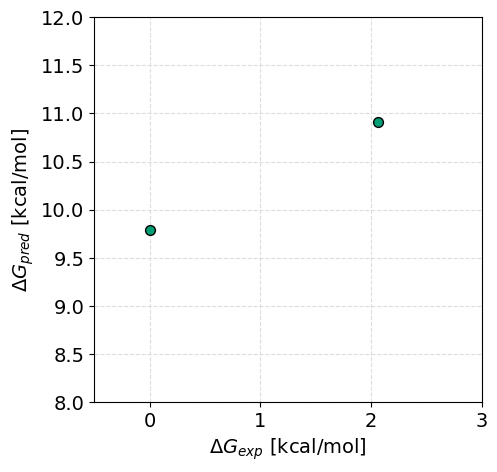

In [222]:
fig,ax1=plt.subplots(1,1,figsize=(5,5))
ax1.scatter([0,2.06],[pred_dg_2CLB_IF,pred_dg_3DMV_IF],facecolor='#009e74', edgecolor='k',s=50,zorder=1000)
ax1.set_xlim(-0.5,3)
ax1.set_ylim(8,12)
ax1.grid(which='major', color='#DDDDDD', linewidth=0.8,ls='--')
ax1.set_axisbelow(True)

ax1.set_xlabel(r'$\Delta G_{exp}$ [kcal/mol]',fontsize=14)
ax1.set_ylabel(r'$\Delta G_{pred}$ [kcal/mol]',fontsize=14)

plt.savefig('./figures_SI/t4_wang2016_comparison.pdf')

### CYPA - Fraser,2009


In [223]:
CYPAmut_seq= 'MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGFGYKGSCFHRIIPGFMCQGGDFTRHNGTGGKSIYGEKFEDENFILKHTGPGILTMANAGPNTNGSQFFICTAKTEWLDGKHVVFGKVKEGMNIVEAMERFGSRNGKTSKKITIADCGQLE'
CYPAwt_seq=  'MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGFGYKGSCFHRIIPGFMCQGGDFTRHNGTGGKSIYGEKFEDENFILKHTGPGILSMANAGPNTNGSQFFICTAKTEWLDGKHVVFGKVKEGMNIVEAMERFGSRNGKTSKKITIADCGQLE'

In [224]:
data_IF_abs=load_data_abs('./fraser2009/IF_run_absolute/prism_ESM_IF_3K0N_A_absolute.txt',CYPAwt_seq)
dg_3K0N_IF=wt_ll(data_IF_abs,CYPAwt_seq,alphabetAA_L_D)
pred_dg_3K0N_IF=linear_curve(dg_3K0N_IF,a_if, b_if)

data_IF_abs=load_data_abs('./fraser2009/IF_run_absolute/prism_ESM_IF_3K0O_A_absolute.txt',CYPAwt_seq)
dg_3K0O_IF=wt_ll(data_IF_abs,CYPAwt_seq,alphabetAA_L_D)
pred_dg_3K0O_IF=linear_curve(dg_3K0O_IF,a_if, b_if)

data_IF_abs=load_data_abs('./fraser2009/IF_run_absolute/prism_ESM_IF_3K0O_A_absolute.txt',CYPAmut_seq)
dg_3K0O_IF_mut=wt_ll(data_IF_abs,CYPAmut_seq,alphabetAA_L_D)
pred_dg_3K0O_IF_mut=linear_curve(dg_3K0O_IF_mut,a_if, b_if)

In [225]:
pred_dg_3K0O_IF_mut

13.995790130969766

In [226]:
pred_dg_3K0O_IF

14.099163246536015

In [227]:
pred_dg_3K0N_IF-pred_dg_3K0O_IF_mut

0.31715816536202013

In [228]:
dG_between_states=1.4 #kcalmol # (eisenmesser,2005)

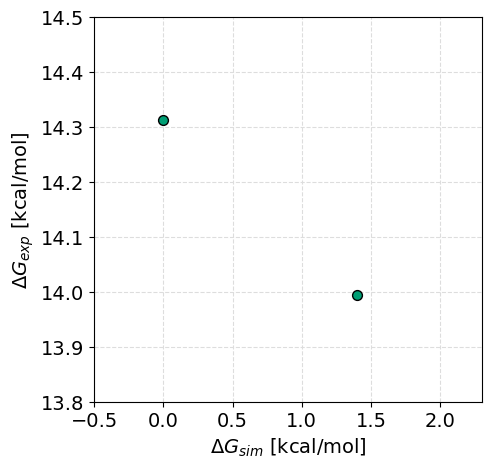

In [229]:
fig,(ax1)=plt.subplots(1,1,figsize=(5,5))
ax1.scatter([0,1.4],[pred_dg_3K0N_IF,pred_dg_3K0O_IF_mut],facecolor='#009e74', edgecolor='k',s=50,zorder=1000)
ax1.set_xlim(-0.5,2.3)
ax1.set_ylim(13.8,14.5)
ax1.grid(which='major', color='#DDDDDD', linewidth=0.8,ls='--')
ax1.set_axisbelow(True)

ax1.set_xlabel(r'$\Delta G_{sim}$ [kcal/mol]',fontsize=14)
ax1.set_ylabel(r'$\Delta G_{exp}$ [kcal/mol]',fontsize=14)

plt.savefig('./figures_SI/CYPA_fraser_2009_comparison.pdf')

### 3states prot


In [230]:
BETA_AF_full_seq= 'MKLWFSTLKLKKAAAVLLFSCVALAGCANNQTNASQPAEKNEKTEMKDDFAKLEEQFDAKLGIFALDTGTNRTVAYRPDERFAFASTIKALTVGVLLQQKSIEDLNQRITYTRDDLVNYNPITEKHVDTGMTLKELADASLRYSDNAAQNLILKQIGGPESLKKELRKIGDEVTNPERFEPELNEVNPGETQDTSTARALVTSLRAFALEDKLPSEKRELLIDWMKRNTTGDALIRAGVPDGWEVADKTGAASYGTRNDIAIIWPPKGDPVVLAVLSSRDKKDAKYDDKLIAEATKVVMKALNMNGK'
            

In [231]:
beta_real_dg=10.6

In [232]:
data_IF_abs=load_data_abs('./non_2states_proteins/prism_ESM-IF_AF_P00808_full_absolute.txt',BETA_AF_full_seq)
dg_BETA_AF_full_IF=wt_ll(data_IF_abs,BETA_AF_full_seq,alphabetAA_L_D)
pred_dg_BETA_AF_full_IF=linear_curve(dg_BETA_AF_full_IF,a_if, b_if)

In [233]:
pred_dg_BETA_AF_full_IF

19.281447354005664

In [234]:
P00563_seq='MPFGNTHNKYKLNYKSEEEYPDLSKHNNHMAKVLTPDLYKKLRDKETPSGFTLDDVIQTGVDNPGHPFIMTVGCVAGDEESYTVFKDLFDPIIQDRHGGFKPTDKHKTDLNHENLKGGDDLDPHYVLSSRVRTGRSIKGYTLPPHCSRGERRAVEKLSVEALNSLTGEFKGKYYPLKSMTEQEQQQLIDDHFLFDKPVSPLLLASGMARDWPDARGIWHNDNKSFLVWVNEEDHLRVISMEKGGNMKEVFRRFCVGLQKIEEIFKKAGHPFMWNEHLGYVLTCPSNLGTGLRGGVHVKLAHLSKHPKFEEILTRLRLQKRGTGGVDTAAVGSVFDISNADRLGSSEVEQVQLVVDGVKLMVEMEKKLEKGQSIDDMIPAQK'

In [235]:
P00562_real_dg_nozn=3.59+4.06

In [236]:
data_IF_abs=load_data_abs('./non_2states_proteins/prism_ESM-IF_P00563_absolute.txt',P00563_seq)
dg_P00563_full_IF=wt_ll(data_IF_abs,P00563_seq,alphabetAA_L_D)
pred_dg_P00563_full_IF=linear_curve(dg_P00563_full_IF,a_if, b_if)

In [237]:
pred_dg_P00563_full_IF

25.747688469491024

In [238]:
results_conct=np.array([beta_real_dg,pred_dg_BETA_AF_full_IF,0,0,P00562_real_dg_nozn,pred_dg_P00563_full_IF])

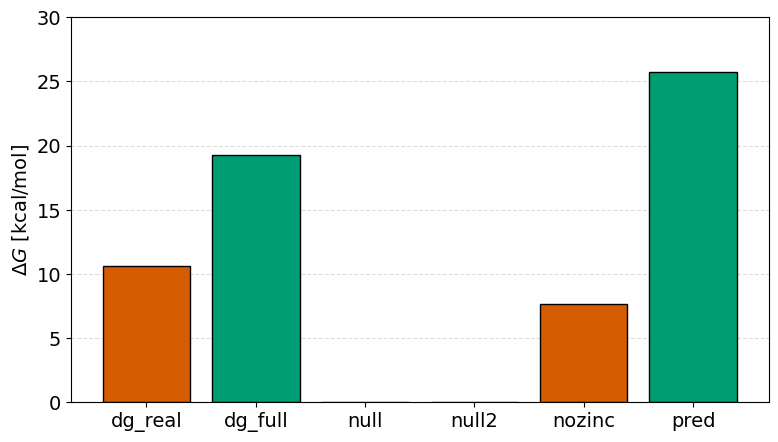

In [239]:
fig,ax=plt.subplots(1,1,figsize=(9,5))

ax.bar(['dg_real','dg_full','null','null2','nozinc','pred'],results_conct,
        edgecolor='k',
        color = ['#d55c00', '#009e74','white','white', '#d55c00' , '#009e74'])

ax.set_ylim(0,30)
ax.grid(axis='y',which='major', color='#DDDDDD', linewidth=0.8,ls='--')
ax.set_axisbelow(True)

ax.set_ylabel(r'$\Delta G$ [kcal/mol]',fontsize=14)
plt.savefig('./figures_SI/figsi_3states_prots.pdf')